In [1]:
import os
from operator import itemgetter    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

import tensorflow as tf

from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical
 
from keras.datasets import imdb

In [2]:
# Load the data
(train_samples, train_labels), (test_samples, test_labels) = imdb.load_data(num_words=10000)

# Look at the shape
train_samples.shape, train_labels.shape, test_samples.shape, test_labels.shape

((25000,), (25000,), (25000,), (25000,))

### Manually encoding with homemade function

In [3]:
# Function to decode the reviews

def vectorize_sequences(sequences, dimension=10000):
    # Initialize a numpy array of zeros with shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    
    # Iterate through each sequence and its index using the built-in enumerate function
    for i, sequence in enumerate(sequences):
        # Set the i-th row of results to 1 at the indices specified by sequence
        # This is a "one-hot encoding" representation of the sequence
        results[i, sequence] = 1.
    
    # Return the resulting numpy array
    return results

In [4]:
x_train = vectorize_sequences(train_samples)
x_test = vectorize_sequences(test_samples)

print("x_train ", x_train.shape)
print("x_test ", x_test.shape)

x_train  (25000, 10000)
x_test  (25000, 10000)


### Tokenizer encoder 

In [14]:
from keras.preprocessing.text import Tokenizer

train_samples = str(train_samples)
train_samples.lower()

test_samples = str(test_samples)
test_samples.lower()

# Create a tokenizer and fit it on the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_samples)

tokenizer.fit_on_texts(test_samples)

# Get the one-hot encoded representation of the text data
one_hot_results_x_train = tokenizer.texts_to_matrix(train_samples, mode='binary')
one_hot_results_x_test = tokenizer.texts_to_matrix(test_samples, mode='binary')

### Vectorize the labels into floats (necessary for working with tensor)

In [15]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
print("y_train ", y_train.shape)
print("y_test ", y_test.shape)

y_train  (25000,)
y_test  (25000,)


### Splitting the data for Validation

In [16]:
# Set a VALIDATION set

x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

print("x_val ", x_val.shape)
print("partial_x_train ", partial_x_train.shape)
print("y_val ", y_val.shape)
print("partial_y_train ", partial_y_train.shape)

x_val  (10000, 10000)
partial_x_train  (15000, 10000)
y_val  (10000,)
partial_y_train  (15000,)


### Initialize the DEEP model 

In [17]:
# Use of DROPOUT

model = models.Sequential()
model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.001),activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [18]:
# FIT / TRAIN model

from keras.callbacks import EarlyStopping

NumEpochs = 50
BatchSize = 512

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# define early stopping criteria
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(partial_x_train, partial_y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(x_val, y_val), callbacks=[earlystop])

results = model.evaluate(x_test, y_test)
print("_"*100)
print("Test Loss and Accuracy")
print("results ", results)
history_dict = history.history
history_dict.keys()


Epoch 1/50
30/30 [==============================] - 8s 116ms/step - loss: 1.2200 - acc: 0.6242 - val_loss: 0.8026 - val_acc: 0.6437
Epoch 2/50
30/30 [==============================] - 1s 45ms/step - loss: 0.7822 - acc: 0.7273 - val_loss: 0.7433 - val_acc: 0.7902
Epoch 3/50
30/30 [==============================] - 1s 47ms/step - loss: 0.7465 - acc: 0.7667 - val_loss: 0.7007 - val_acc: 0.8325
Epoch 4/50
30/30 [==============================] - 1s 48ms/step - loss: 0.7108 - acc: 0.7931 - val_loss: 0.6706 - val_acc: 0.8530
Epoch 5/50
30/30 [==============================] - 1s 46ms/step - loss: 0.6891 - acc: 0.8003 - val_loss: 0.6392 - val_acc: 0.8572
Epoch 6/50
30/30 [==============================] - 1s 44ms/step - loss: 0.6677 - acc: 0.8105 - val_loss: 0.6046 - val_acc: 0.8608
Epoch 7/50
30/30 [==============================] - 1s 45ms/step - loss: 0.6508 - acc: 0.8182 - val_loss: 0.5882 - val_acc: 0.8563
Epoch 8/50
30/30 [==============================] - 3s 87ms/step - loss: 0.6375 - 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

### Evaluate the model 

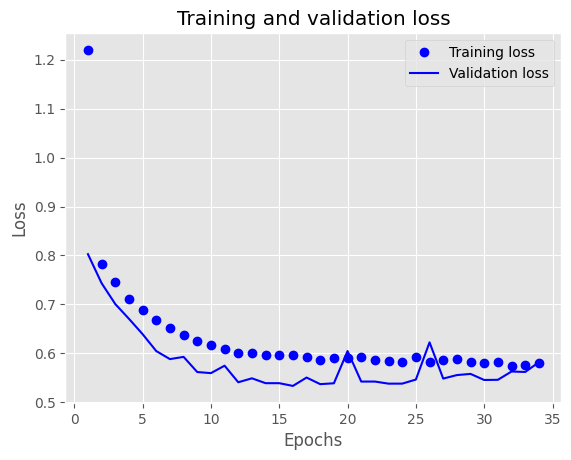

In [19]:
# VALIDATION LOSS curves

plt.clf()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

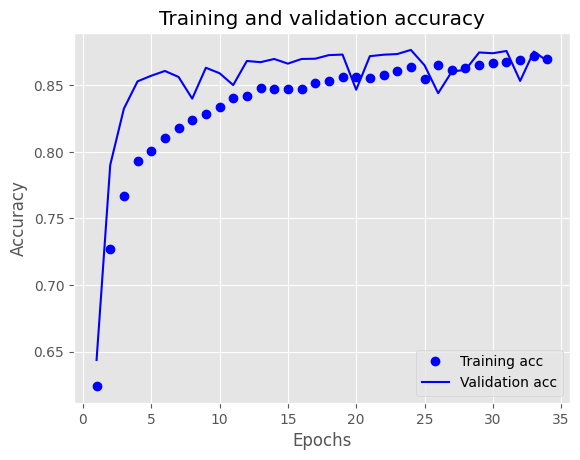

In [20]:
# VALIDATION ACCURACY curves

plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, (len(history_dict['acc']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

782/782 [==============================] - 4s 5ms/step


<Axes: >

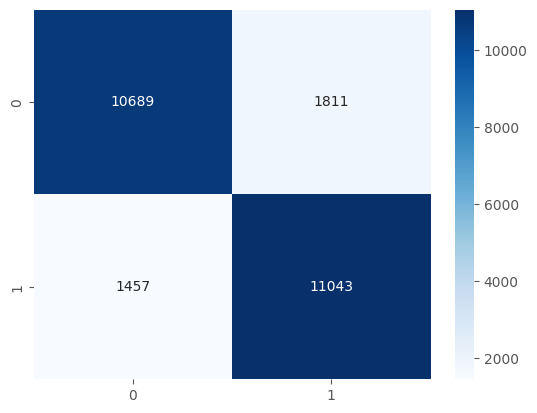

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_test_predictions = model.predict(x_test)
y_test_predictions = (y_test_predictions > 0.5)

conf_matrix = confusion_matrix(y_test, y_test_predictions)

# Display the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')


782/782 [==============================] - 4s 5ms/step


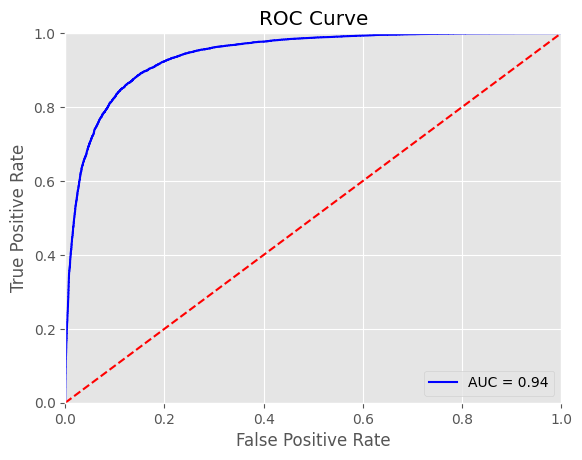

In [41]:
import sklearn.metrics as metrics

y_pred = model.predict(x_test)
y_pred_proba = y_pred.ravel()  # Reshape to 1-dimensional array
# Make predictions on the test set
y_pred = model.predict(x_test)
y_test = y_test.ravel()  # Reshape to 1-dimensional array

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
